In [1]:
import scanpy as sc

In [2]:
adata = sc.read_csv('data/raw_counts/GSM5226574_C51ctr_raw_counts.csv.gz').T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [3]:
adata.X.shape

(6099, 34546)

In [4]:
#Doublet Removal

In [5]:
import scvi

Global seed set to 0
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [7]:
sc.pp.filter_genes(adata, min_cells=10) #Keeping genes that are found in at least 10 cells  

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes= 2000, subset = True, flavor= 'cell_ranger')

In [9]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [12:49<00:00,  1.13s/it, loss=123, v_num=1]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [12:49<00:00,  1.92s/it, loss=123, v_num=1]


In [10]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 207/400:  52%|█████▏    | 207/400 [00:52<00:48,  3.97it/s, loss=0.367, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.367. Signaling Trainer to stop.


In [11]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
TAGGTACCATGGCCAC-1_1,0.051032,-1.968385,doublet
ATTCACTGTAACAGGC-1_1,-0.242125,-1.781615,doublet
TAACTTCCAACCACGC-1_1,0.057808,-1.425936,doublet
TTGGGTACACGACAAG-1_1,-0.131093,-1.531041,doublet
AGGCCACAGAGTCACG-1_1,-0.323002,-1.536047,doublet
...,...,...,...
CGCCATTGTTTGCCGG-1_1,-1.140550,0.676906,singlet
CACTGGGGTCTACGTA-1_1,-4.140431,4.022964,singlet
CATACTTGTAGAGGAA-1_1,-4.330626,4.170394,singlet
TTTGGTTTCCACGGAC-1_1,-1.744743,2.009115,singlet


In [12]:
df.groupby('prediction').count()

,doublet,singlet
prediction,,
doublet,1775,1775
singlet,4324,4324


In [13]:
df['Diff'] = df.doublet - df.singlet
df

,doublet,singlet,prediction,Diff
TAGGTACCATGGCCAC-1_1,0.051032,-1.968385,doublet,2.019418
ATTCACTGTAACAGGC-1_1,-0.242125,-1.781615,doublet,1.539490
TAACTTCCAACCACGC-1_1,0.057808,-1.425936,doublet,1.483744
TTGGGTACACGACAAG-1_1,-0.131093,-1.531041,doublet,1.399948
AGGCCACAGAGTCACG-1_1,-0.323002,-1.536047,doublet,1.213045
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,-1.140550,0.676906,singlet,-1.817457
CACTGGGGTCTACGTA-1_1,-4.140431,4.022964,singlet,-8.163395
CATACTTGTAGAGGAA-1_1,-4.330626,4.170394,singlet,-8.501020
TTTGGTTTCCACGGAC-1_1,-1.744743,2.009115,singlet,-3.753859


In [14]:
import seaborn as sns

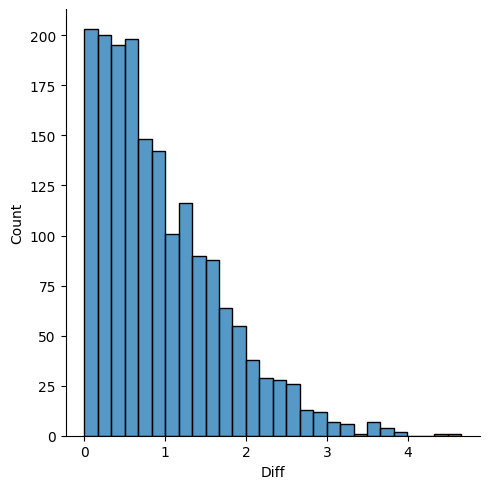

In [15]:
sns.displot(df[df.prediction == 'doublet'], x = 'Diff')

In [16]:
doublets = df[(df.prediction == 'doublet') & (df.Diff>1)]
doublets #reads that were predicted doublets with high certainty

,doublet,singlet,prediction,Diff
TAGGTACCATGGCCAC-1_1,0.051032,-1.968385,doublet,2.019418
ATTCACTGTAACAGGC-1_1,-0.242125,-1.781615,doublet,1.539490
TAACTTCCAACCACGC-1_1,0.057808,-1.425936,doublet,1.483744
TTGGGTACACGACAAG-1_1,-0.131093,-1.531041,doublet,1.399948
AGGCCACAGAGTCACG-1_1,-0.323002,-1.536047,doublet,1.213045
...,...,...,...,...
GGTTCTCTCCTAGAGT-1_1,0.582781,-0.583164,doublet,1.165945
TGCTCGTGTGTCCTAA-1_1,0.920968,-0.862371,doublet,1.783340
GCCATTCCACTGCACG-1_1,0.832453,-0.917410,doublet,1.749863
TCCGAAAAGGGACCAT-1_1,0.648061,-0.550436,doublet,1.198497


In [17]:
adata = sc.read_csv('data/raw_counts/GSM5226574_C51ctr_raw_counts.csv.gz').T

In [18]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [19]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,True
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [20]:
adata = adata[~adata.obs.doublet]

In [21]:
adata# object with doublets removed

View of AnnData object with n_obs × n_vars = 5410 × 34546
    obs: 'doublet'

# **Preprocessing**

In [22]:
adata.var

""
AL627309.1
AL627309.5
AL627309.4
AL669831.2
LINC01409
...
VN1R2
AL031676.1
SMIM34A
AL050402.1


In [23]:
#Filtering out the mitochondrial genes
adata.var['mt'] = adata.var.index.str.startswith('MT-') #Humans have the MT symbol

/var/folders/lm/hv5s2ytj6jjfkgp634xv15180000gn/T/ipykernel_26632/255422824.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var.index.str.startswith('MT-') #Humans have the MT symbol


In [24]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


In [25]:
#List of ribosomal genes that can be imported from the broad institute
import pandas as pd

In [26]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [27]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [28]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [29]:
adata.obs

,doublet
TTGGTTTTCCTAGCTC-1_1,False
CACTTCGCAGTACTAC-1_1,False
AAGAACATCGGATTAC-1_1,False
GGGTATTGTACGATGG-1_1,False
CTGTAGATCAACGTGT-1_1,False
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [30]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [31]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
IGKV1-5,False,False,0,0.000000,100.000000,0.0
IGKV1-6,False,False,0,0.000000,100.000000,0.0
IGKV3-15,False,False,0,0.000000,100.000000,0.0
IGKV6-21,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,3857,2.774122,28.706100,15008.0
NEAT1,False,False,3890,4.669870,28.096118,25264.0
MBNL1,False,False,3950,2.621811,26.987061,14184.0
ZBTB20,False,False,4067,2.329575,24.824399,12603.0


In [32]:
sc.pp.filter_genes(adata, min_cells=3)

In [33]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
LINC02757,False,False,3,0.000555,99.944547,3.0,3
AC079322.1,False,False,3,0.000555,99.944547,3.0,3
AC073270.2,False,False,3,0.000555,99.944547,3.0,3
HCN4,False,False,3,0.000555,99.944547,3.0,3
AC090826.1,False,False,3,0.000555,99.944547,3.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,3857,2.774122,28.706100,15008.0,3857
NEAT1,False,False,3890,4.669870,28.096118,25264.0,3890
MBNL1,False,False,3950,2.621811,26.987061,14184.0,3950
ZBTB20,False,False,4067,2.329575,24.824399,12603.0,4067


In [34]:
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
CAGGGCTTCATGCGGC-1_1,False,330,401.0,7.0,1.745636,1.0,0.249377
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
CCTTGTGCAGAGGGTT-1_1,False,3101,7654.0,575.0,7.512412,9.0,0.117586
GGGTATTGTACGATGG-1_1,False,3362,7723.0,337.0,4.363589,6.0,0.077690
AAGAACATCGGATTAC-1_1,False,3384,7775.0,86.0,1.106109,8.0,0.102894
CACTTCGCAGTACTAC-1_1,False,3244,8059.0,253.0,3.139347,14.0,0.173719


In [35]:
#sc.pp.filter_cells(adata, min_genes=200)

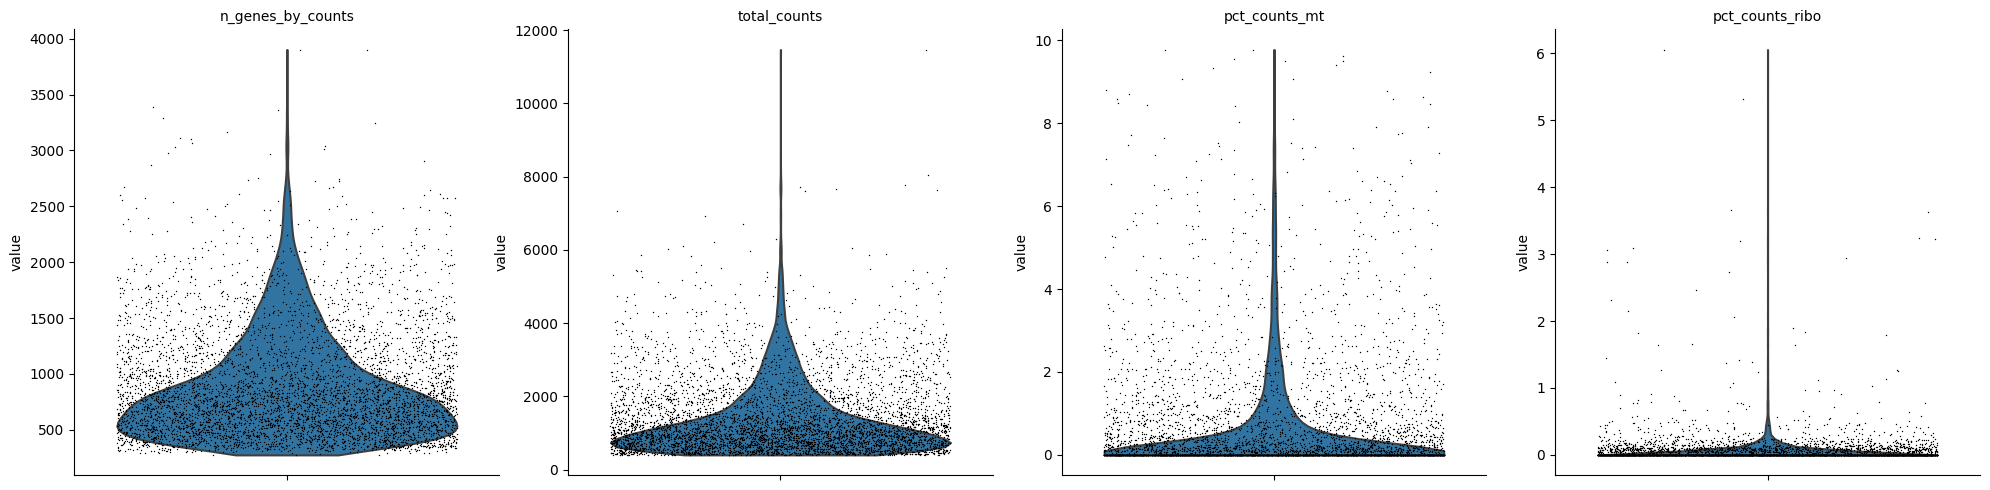

In [36]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

In [37]:
import numpy as np

In [38]:
#piclking the 98th percentile
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
upper_lim

2144.6399999999994

In [39]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [40]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246
AGGGCCTGTTGCTTGA-1_1,False,1876,4493.0,2.0,0.044514,2.0,0.044514
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [41]:
adata = adata[adata.obs.pct_counts_mt < 20]

In [42]:
adata = adata[adata.obs.pct_counts_ribo < 2]

In [43]:
adata

View of AnnData object with n_obs × n_vars = 5284 × 23722
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# **Normalization**

In [44]:
adata.X.sum(axis = 1)

array([5250., 4727., 4597., ...,  410.,  405.,  410.], dtype=float32)

In [45]:
#Normalizing each cell so that their total counts are the same across
sc.pp.normalize_total(adata, target_sum=1e4) #every cell to 10,000 UMI

/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [46]:
adata.X.sum(axis = 1)

array([10000.001, 10000.   , 10000.   , ..., 10000.   , 10000.   ,
        9999.999], dtype=float32)

In [47]:
#converting to log counts
sc.pp.log1p(adata)

In [48]:
adata.X.sum(axis = 1)

array([2858.1602, 3120.9375, 2950.6418, ..., 1191.2706, 1022.7511,
       1162.8785], dtype=float32)

In [49]:
adata.raw = adata

# **Clustering**

In [50]:
sc.pp.highly_variable_genes(adata, n_top_genes= 2000)

In [51]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,7,0.001294,99.870610,7.0,7,True,0.011569,2.764047,1.191767
AL627309.5,False,False,21,0.003882,99.611830,21.0,21,False,0.026760,2.392071,0.006002
AL627309.4,False,False,3,0.000555,99.944547,3.0,3,False,0.001745,1.775269,-1.960211
LINC01409,False,False,208,0.042144,96.155268,228.0,208,False,0.264299,2.367289,-0.072997
FAM87B,False,False,4,0.000739,99.926063,4.0,4,False,0.005286,1.980307,-1.306601
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,108,0.020702,98.003697,112.0,108,False,0.155741,2.443010,0.168383
AL592183.1,False,False,809,0.174492,85.046211,944.0,809,False,0.877876,2.531955,-0.410453
AC240274.1,False,False,116,0.022366,97.855823,121.0,116,False,0.144920,2.361324,-0.092014
AC007325.4,False,False,4,0.000739,99.926063,4.0,4,False,0.002661,1.662094,-2.320986


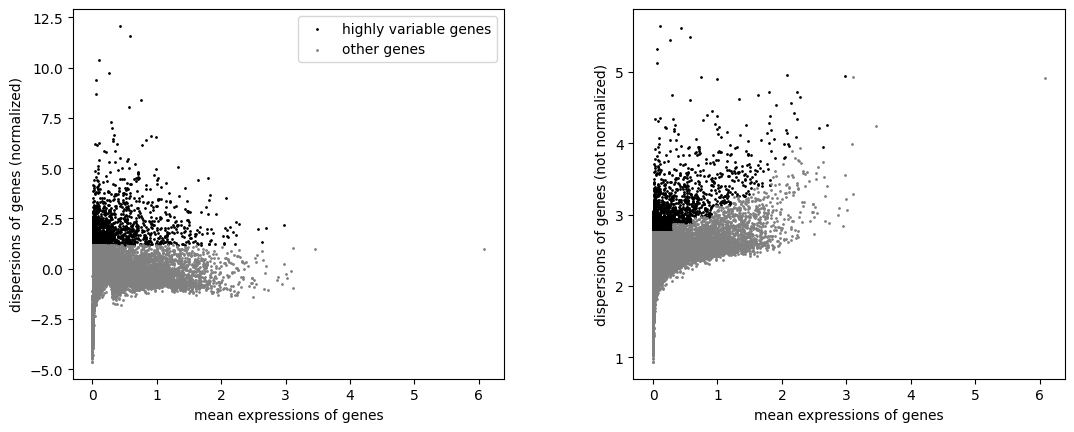

In [52]:
#Filtering out less variable genes 
#First visualize this 
sc.pl.highly_variable_genes(adata)

In [53]:
adata = adata[:, adata.var.highly_variable]

In [54]:
adata

View of AnnData object with n_obs × n_vars = 5284 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [55]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

In [56]:
sc.pp.scale(adata, max_value=10)

In [57]:
sc.tl.pca(adata, svd_solver='arpack')

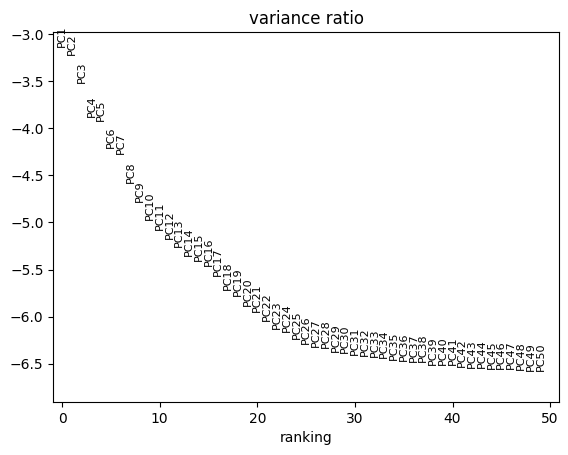

In [58]:
#Plotting the ELBO like plot
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [59]:
#Calculating the neigbors of the cells
sc.pp.neighbors(adata, n_pcs=30)

In [60]:
adata.obsp['connectivities'].toarray()

array([[0.       , 0.       , 0.3010795, ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.3010795, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [61]:
sc.tl.umap(adata)

/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


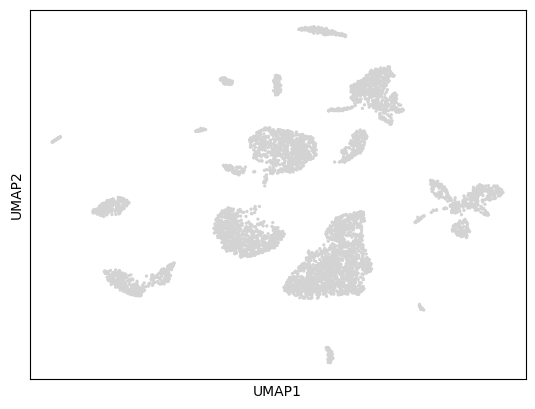

In [62]:
sc.pl.umap(adata)

In [63]:
sc.tl.leiden(adata, resolution=0.5)

In [64]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301,1
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246,2
AGGGCCTGTTGCTTGA-1_1,False,1876,4493.0,2.0,0.044514,2.0,0.044514,2
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000,1
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,8
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,11


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


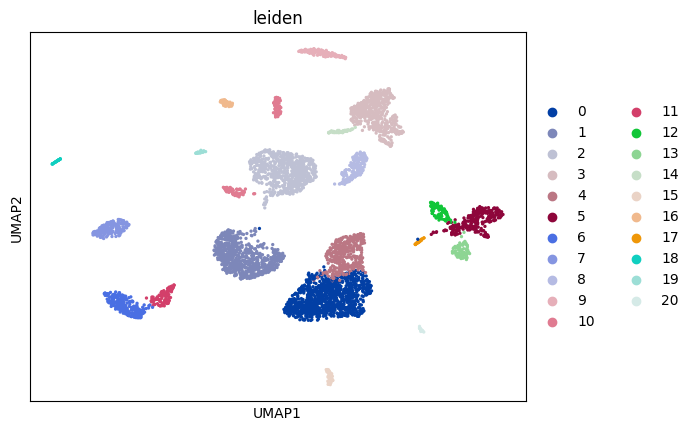

In [65]:
sc.pl.umap(adata, color=['leiden'])

In [66]:
adata.write_h5ad('first_sample.h5ad')

# **Integration**

In [67]:
#Taking all these commands above and defining a function that does this for every sample and integrates it into one adata file

def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor= 'cell_ranger')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [68]:
import os 

In [69]:
out=[]

for sample in os.listdir('data/raw_counts/'):
    out.append(pp('data/raw_counts/' + sample))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [05:26<00:00,  1.59it/s, loss=164, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:26<00:00,  1.22it/s, loss=164, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 383/400:  96%|█████████▌| 383/400 [00:50<00:02,  7.62it/s, loss=0.271, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.250. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:25<00:00,  2.03it/s, loss=163, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:25<00:00,  1.95it/s, loss=163, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 131/400:  33%|███▎      | 131/400 [00:14<00:29,  9.23it/s, loss=0.328, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.320. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [05:40<00:00,  1.45it/s, loss=175, v_num=1]  

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:40<00:00,  1.17it/s, loss=175, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 352/400:  88%|████████▊ | 352/400 [00:40<00:05,  8.70it/s, loss=0.277, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.260. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [01:45<00:00,  3.88it/s, loss=263, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:45<00:00,  3.78it/s, loss=263, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 313/400:  78%|███████▊  | 313/400 [00:17<00:04, 17.45it/s, loss=0.317, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.319. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:12<00:00,  2.04it/s, loss=183, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:12<00:00,  2.08it/s, loss=183, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 373/400:  93%|█████████▎| 373/400 [00:36<00:02, 10.23it/s, loss=0.357, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.350. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:00<00:00,  1.68it/s, loss=111, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:00<00:00,  1.66it/s, loss=111, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 162/400:  40%|████      | 162/400 [00:19<00:29,  8.16it/s, loss=0.319, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.297. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:18<00:00,  2.69it/s, loss=257, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:18<00:00,  2.90it/s, loss=257, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 163/400:  41%|████      | 163/400 [00:11<00:17, 13.76it/s, loss=0.359, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.383. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:12<00:00,  2.11it/s, loss=205, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:12<00:00,  2.07it/s, loss=205, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 199/400:  50%|████▉     | 199/400 [00:19<00:20,  9.99it/s, loss=0.27, v_num=1] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.264. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:04<00:00,  1.58it/s, loss=204, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:04<00:00,  1.63it/s, loss=204, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 271/400:  68%|██████▊   | 271/400 [00:34<00:16,  7.79it/s, loss=0.336, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.332. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:43<00:00,  1.55it/s, loss=203, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:43<00:00,  1.79it/s, loss=203, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 180/400:  45%|████▌     | 180/400 [00:21<00:26,  8.28it/s, loss=0.366, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.324. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:06<00:00,  1.65it/s, loss=217, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:06<00:00,  1.62it/s, loss=217, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 125/400:  31%|███▏      | 125/400 [00:16<00:36,  7.63it/s, loss=0.313, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.321. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:01<00:00,  2.19it/s, loss=222, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:01<00:00,  2.21it/s, loss=222, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 216/400:  54%|█████▍    | 216/400 [00:20<00:17, 10.32it/s, loss=0.355, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.361. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:15<00:00,  1.09it/s, loss=130, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:15<00:00,  1.07it/s, loss=130, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 206/400:  52%|█████▏    | 206/400 [00:39<00:37,  5.22it/s, loss=0.369, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.340. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [01:27<00:00,  4.58it/s, loss=233, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:27<00:00,  4.58it/s, loss=233, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 196/400:  49%|████▉     | 196/400 [00:09<00:10, 20.36it/s, loss=0.297, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.338. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:45<00:00,  2.40it/s, loss=230, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:45<00:00,  2.41it/s, loss=230, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 198/400:  50%|████▉     | 198/400 [00:18<00:18, 10.81it/s, loss=0.335, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.345. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:38<00:00,  1.86it/s, loss=178, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:38<00:00,  1.83it/s, loss=178, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 176/400:  44%|████▍     | 176/400 [00:20<00:26,  8.58it/s, loss=0.312, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:43<00:00,  2.49it/s, loss=176, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:43<00:00,  2.45it/s, loss=176, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 153/400:  38%|███▊      | 153/400 [00:12<00:20, 11.88it/s, loss=0.206, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.263. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [05:05<00:00,  1.31it/s, loss=116, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:05<00:00,  1.31it/s, loss=116, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 201/400:  50%|█████     | 201/400 [00:31<00:31,  6.38it/s, loss=0.283, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.306. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:04<00:00,  1.64it/s, loss=205, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:04<00:00,  1.64it/s, loss=205, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 152/400:  38%|███▊      | 152/400 [00:19<00:32,  7.65it/s, loss=0.309, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:32<00:00,  1.91it/s, loss=186, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:32<00:00,  1.89it/s, loss=186, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 353/400:  88%|████████▊ | 353/400 [00:39<00:05,  9.03it/s, loss=0.341, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.311. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:40<00:00,  1.18it/s, loss=184, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:40<00:00,  1.42it/s, loss=184, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 233/400:  58%|█████▊    | 233/400 [00:36<00:26,  6.41it/s, loss=0.426, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.441. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:41<00:00,  1.45it/s, loss=224, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:41<00:00,  1.42it/s, loss=224, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 225/400:  56%|█████▋    | 225/400 [00:31<00:24,  7.10it/s, loss=0.357, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.369. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:58<00:00,  1.01s/it, loss=218, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:58<00:00,  1.05s/it, loss=218, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 155/400:  39%|███▉      | 155/400 [00:32<00:50,  4.83it/s, loss=0.321, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.314. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [04:16<00:00,  1.59it/s, loss=152, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:16<00:00,  1.56it/s, loss=152, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 213/400:  53%|█████▎    | 213/400 [00:27<00:24,  7.65it/s, loss=0.384, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.399. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [06:04<00:00,  1.12it/s, loss=173, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:04<00:00,  1.10it/s, loss=173, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 189/400:  47%|████▋     | 189/400 [00:35<00:39,  5.28it/s, loss=0.356, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.365. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [05:09<00:00,  1.24it/s, loss=125, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:09<00:00,  1.29it/s, loss=125, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 238/400:  60%|█████▉    | 238/400 [00:39<00:27,  5.96it/s, loss=0.36, v_num=1] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.370. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [02:44<00:00,  2.47it/s, loss=216, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:44<00:00,  2.43it/s, loss=216, v_num=1]
INFO     Creating doublets, preparing SOLO model.                                                                  


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 320/400:  80%|████████  | 320/400 [00:28<00:07, 11.12it/s, loss=0.3, v_num=1]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.295. Signaling Trainer to stop.


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [1]:
out[3]

NameError: name 'out' is not defined

In [ ]:
adata = sc.concat(out)
adata

# **Finding Markers/ Labelling Cell Types**

In [5]:
adata = sc.read_h5ad('/Users/michael/Documents/Bioinformatics/Personal_Projects/scRNA/covid_project/processed_data/first_sample.h5ad')

In [6]:
sc.tl.leiden(adata, resolution=1)

In [7]:
sc.tl.rank_genes_groups(adata, 'leiden')

/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.

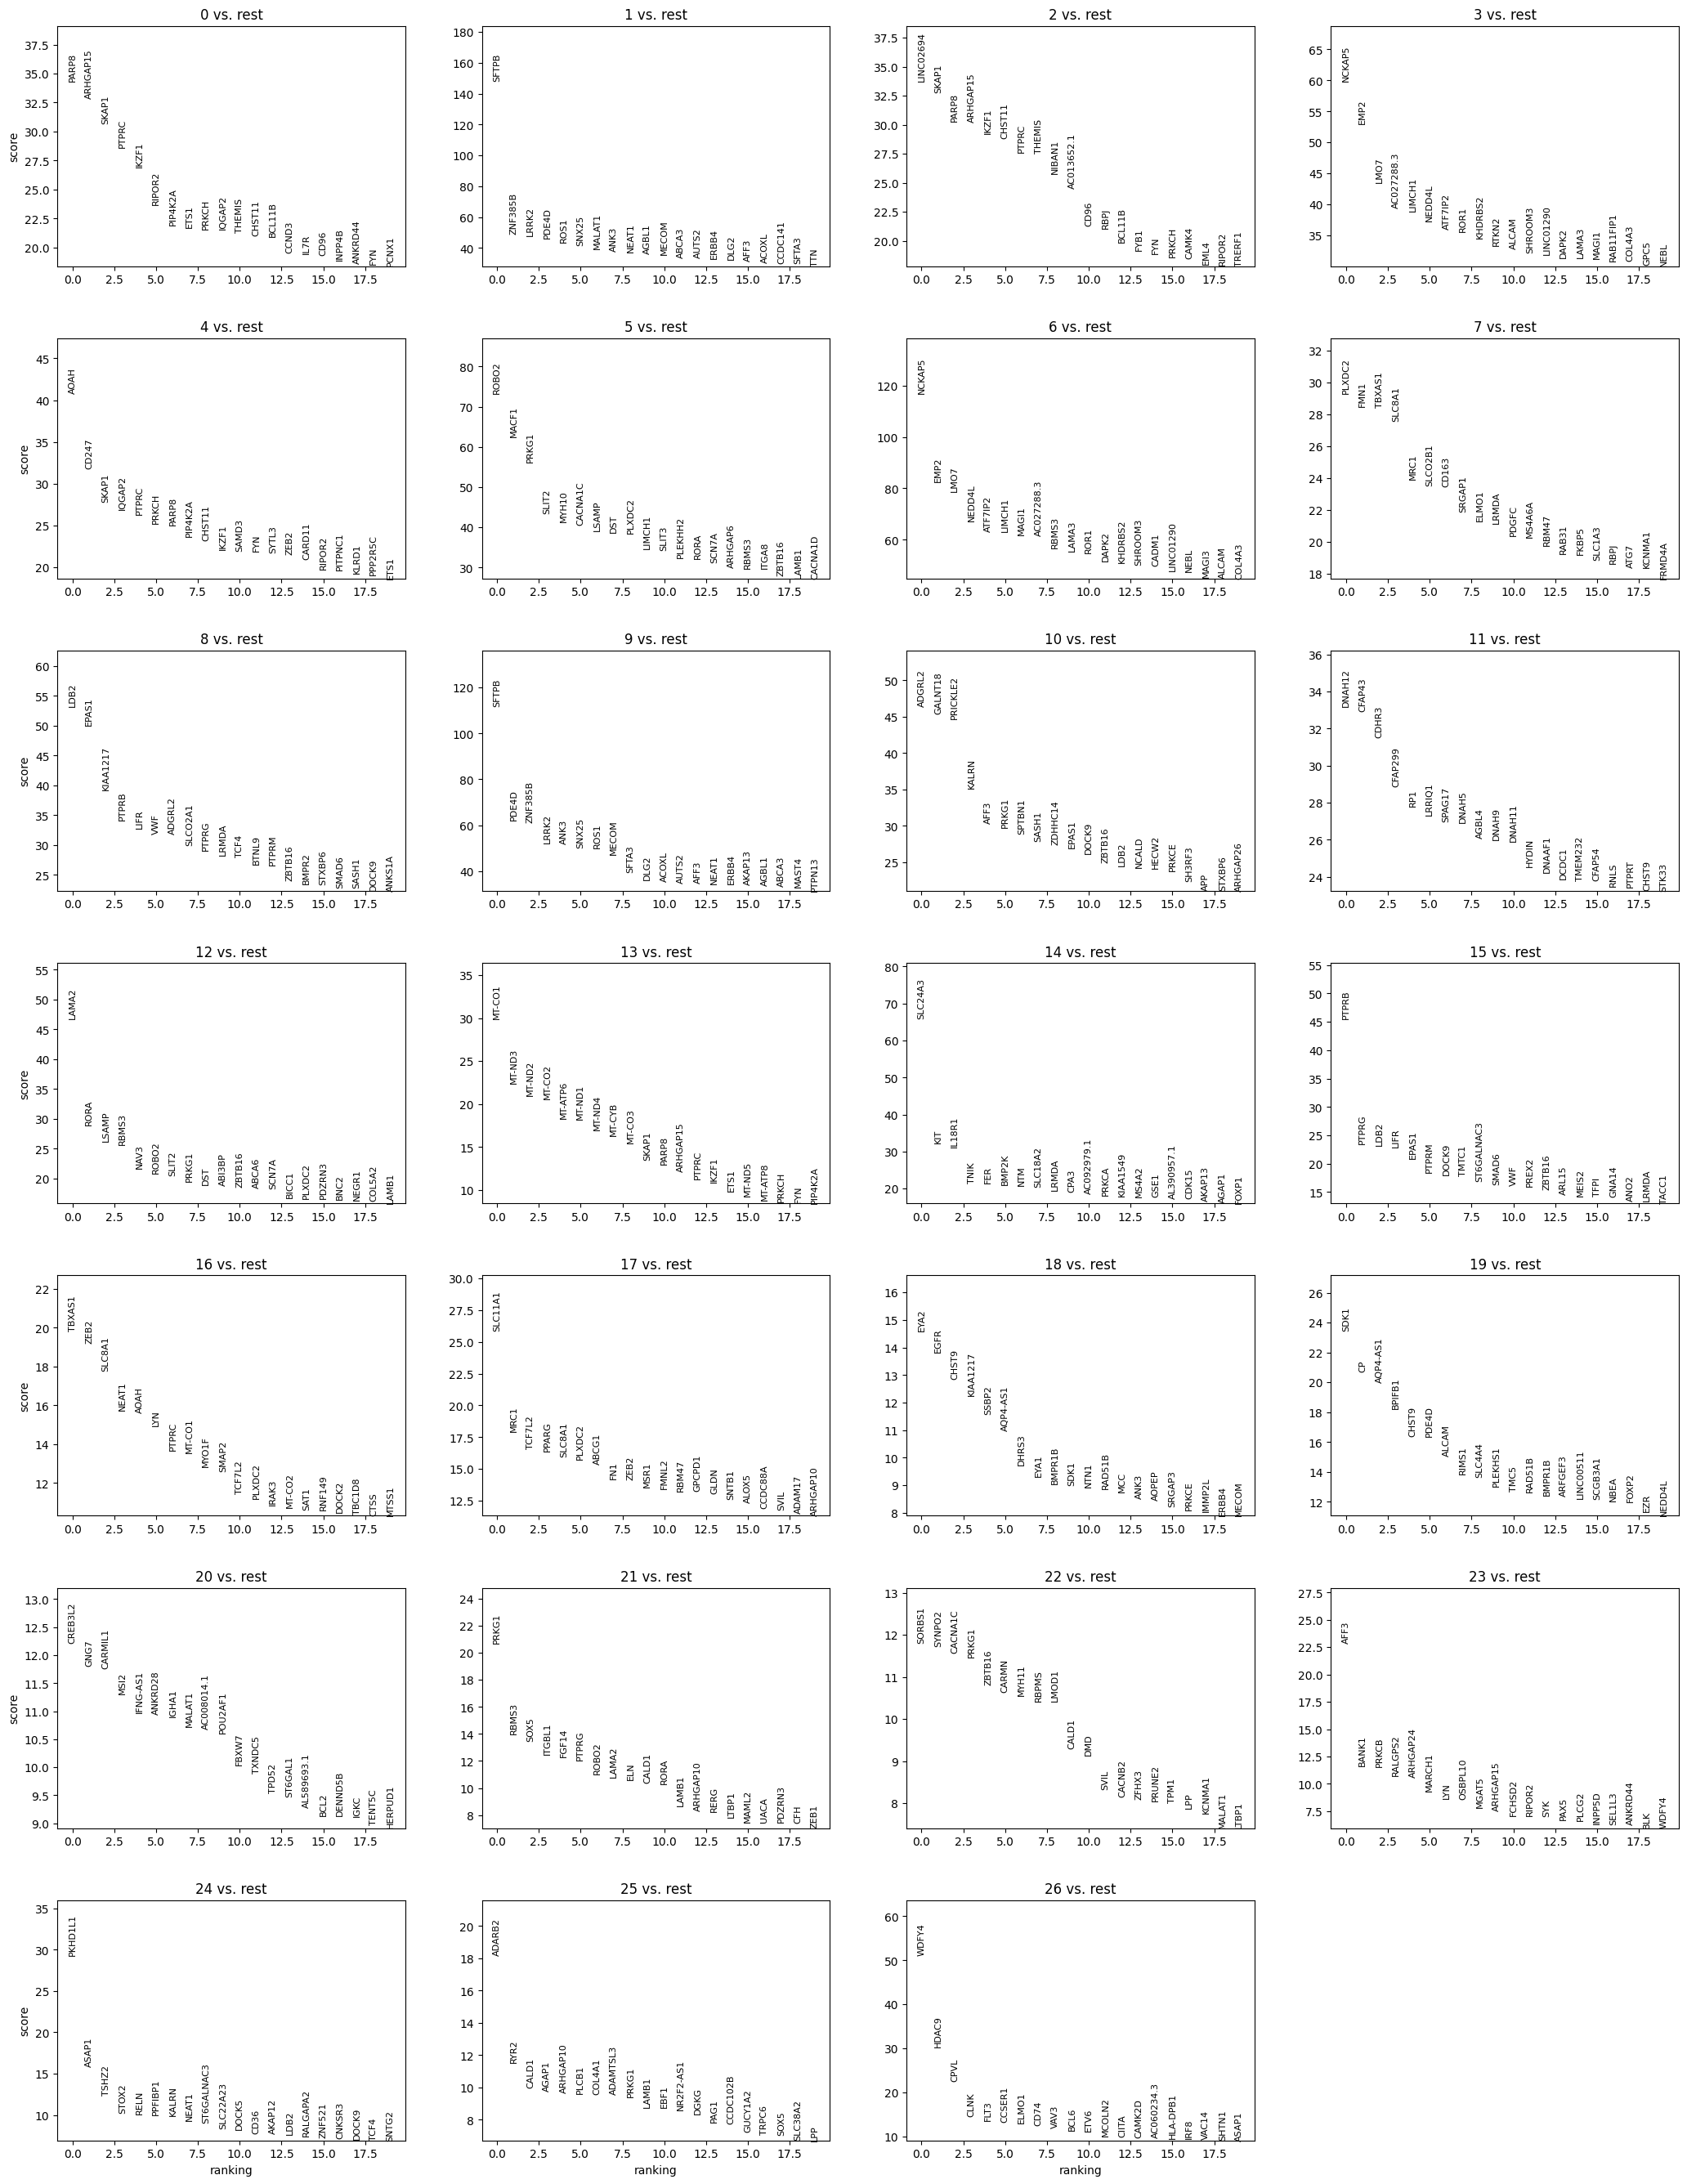

In [8]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [9]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]

In [10]:
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,PARP8,34.340305,3.843508,5.054796e-148,4.835075e-146
1,0,ARHGAP15,32.861519,3.688611,4.525787e-141,3.961650e-139
2,0,SKAP1,30.694727,3.813119,3.109375e-127,2.276561e-125
3,0,PTPRC,28.654284,3.401161,3.643479e-117,2.400850e-115
4,0,IKZF1,26.956011,3.403874,5.116770e-107,2.869504e-105
...,...,...,...,...,...,...
617141,26,PRKAR2B,2.360086,4.576326,3.047822e-02,4.827108e-02
617142,26,YEATS2,2.359220,2.044634,3.049213e-02,4.828989e-02
617143,26,GALNT7,2.358966,2.349411,3.051542e-02,4.832032e-02
617144,26,RAD51B,2.357308,1.870454,3.059276e-02,4.842215e-02


/Users/michael/anaconda3/envs/myscRNAenv/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


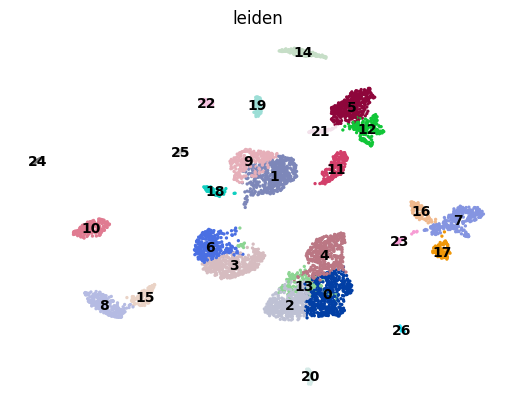

In [11]:
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc= "on data")

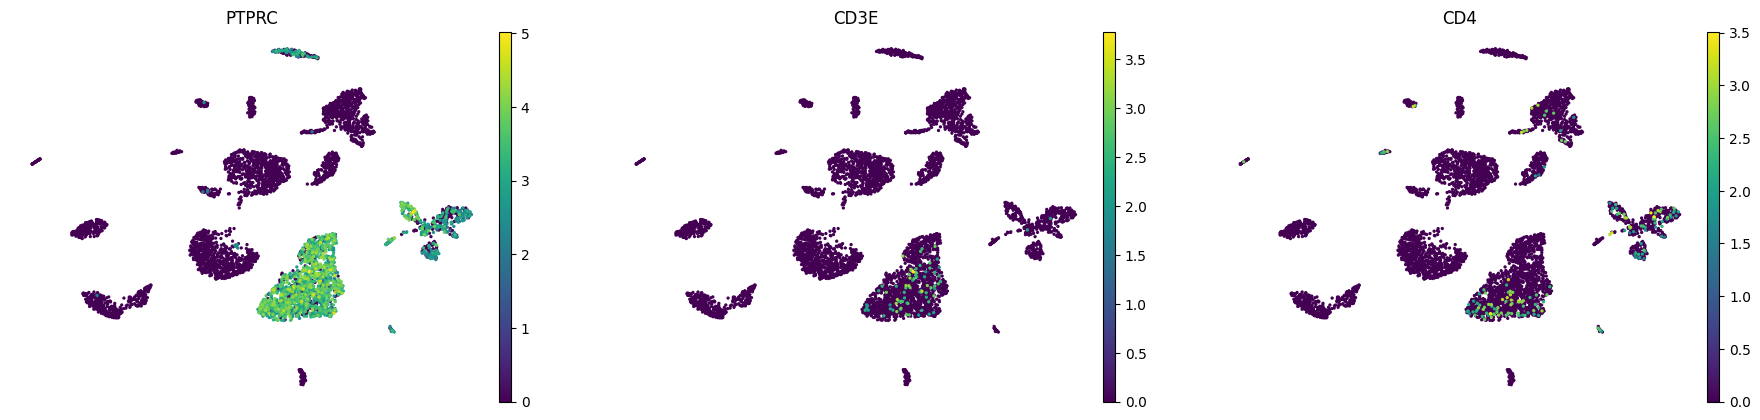

In [12]:
sc.pl.umap(adata, color = ['PTPRC', 'CD3E', 'CD4'], frameon = False)

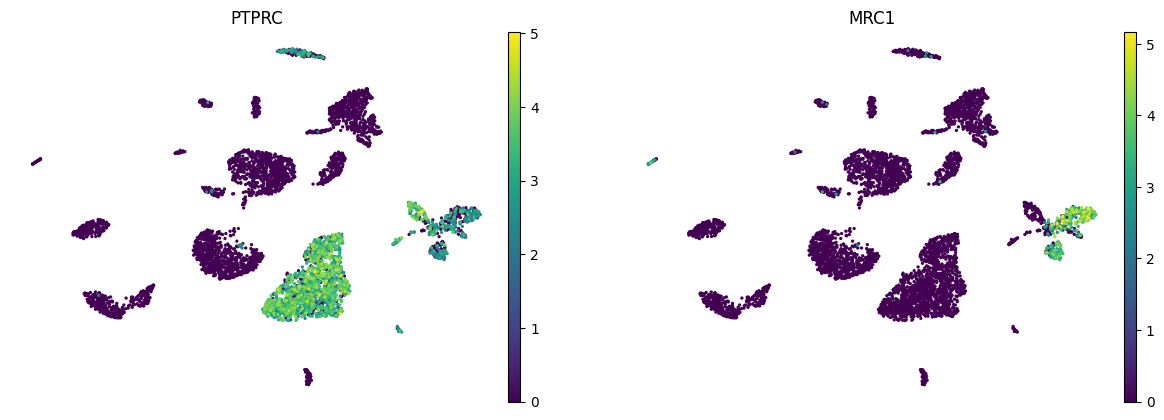

In [13]:
sc.pl.umap(adata, color = ['PTPRC', 'MRC1'], frameon = False)

In [14]:
markers[markers.names == 'CD84']

,group,names,scores,logfoldchanges,pvals,pvals_adj
655,0,CD84,3.865783,1.269290,1.233105e-04,4.461143e-04
47852,2,CD84,5.145687,1.808141,3.882971e-07,1.781660e-06
166289,7,CD84,7.383892,2.901662,1.636641e-12,1.508329e-11
332351,14,CD84,5.253627,2.812567,5.312736e-07,2.381495e-06


In [15]:
markers[markers.names == 'SLC9A2']

,group,names,scores,logfoldchanges,pvals,pvals_adj


In [18]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,leiden
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,9
CATAAGCCACCCAACG-1_1,False,2126,4728.0,1.0,0.021151,2.0,0.042301,6
GATGACTGTACCCAGC-1_1,False,2007,4598.0,6.0,0.130492,3.0,0.065246,9
AGGGCCTGTTGCTTGA-1_1,False,1876,4493.0,2.0,0.044514,2.0,0.044514,9
TGGGCTGTCTACTTCA-1_1,False,2051,4406.0,6.0,0.136178,0.0,0.000000,6
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,11
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,3
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,2
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,15
